# Climate 485 Final Project 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ocean_reflectance import ocean_R
from processing_fns import read_text_file
from processing_fns import total_atmospheric_trans
from processing_fns import tb_polarization
from processing_fns import tb_sensitivity_lst
from processing_fns import tb_sensitivity_lwp
from processing_fns import total_uncertainty
from IPython.display import Image

In [17]:
# load dataframes
df_liq_water = read_text_file("liquid_cloud_ka_0degC.txt", col_names = ['freq_GHz', 'mass_abs'])
df_wv_gases = read_text_file("mw_gas_absorption.txt", col_names = ['freq_GHz', 'dry_air_tau', 'wv_abs'])

## U.S. Standard Atmosphere Transmittance
This will be a major source of uncertainty in our LST estimates. We will likely choose a frequency near/on an atmospheric window.

Text(0.5, 1.0, 'Total Clear Sky Transmittance')

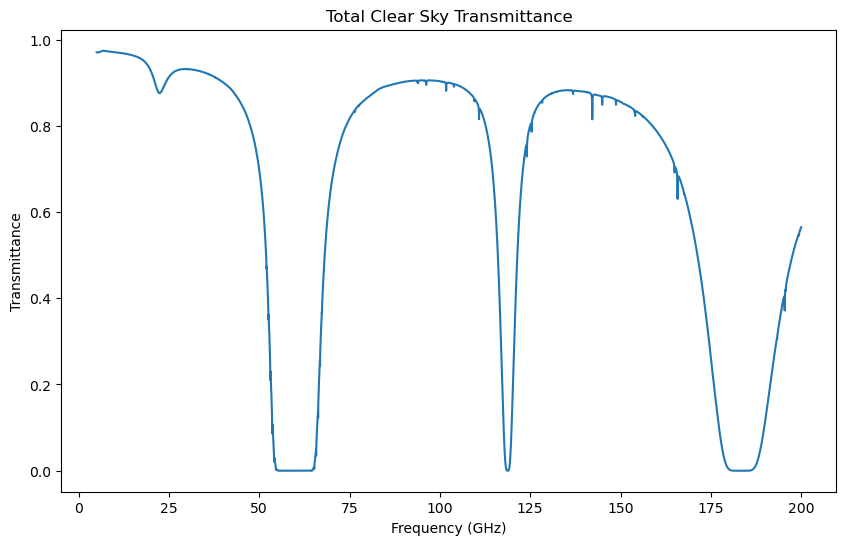

In [219]:
freq = np.array(df_wv_gases.freq_GHz)

# Clear sky, lwp = 0
t_star_clear = total_atmospheric_trans(freq, 0, df_liq_water, df_wv_gases)

# figure and subplots
fig, ax = plt.subplots(1,1, figsize = (10,6))

ax.plot(freq, t_star)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Transmittance")
ax.set_title("Total Clear Sky Transmittance")

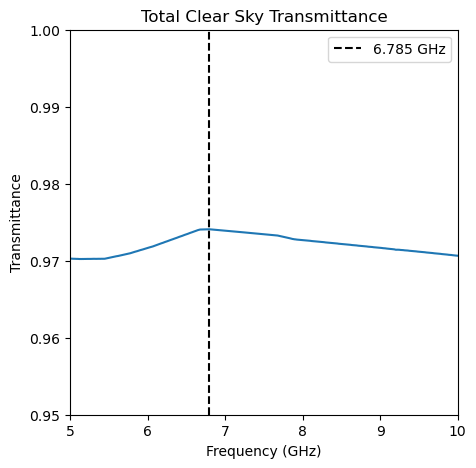

In [221]:
# Zooming into the frequency range with the highest transmittance
fig, ax = plt.subplots(1,1, figsize = (5,5))

ax.plot(freq, t_total)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Transmittance")
ax.set_title("Total Clear Sky Transmittance")
ax.set_xlim([5,10])
ax.set_ylim([0.95,1])

freq_of_max_t = freq[np.argmax(t_total)]
ax.axvline(freq_of_max_t, c = 'black', ls = '--', label = f'{freq_of_max_t} GHz')
ax.legend()

Given the high atmospheric transmission around 6.8 GHz, this should lead to the lowest uncertainty in our measurement, at least for this component of the uncertainty. Nice thing is the amount of water vapor barely affects the transmission in this range.

# Lake-effect Cloud Example (LWP = 0.1 kg/m^2)
## Brightness Temperature of the Lake Surface

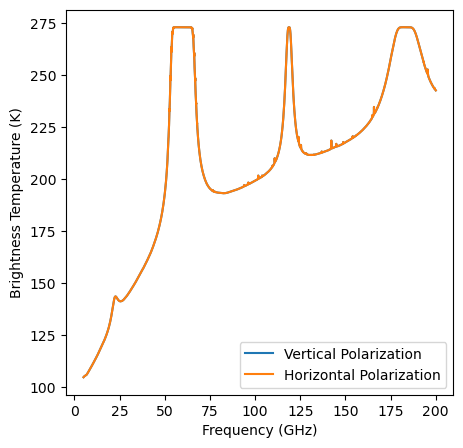

In [230]:
cloud_temp = 273.15 # Use this because the values he gave us for mass extinction coefficient were at 0C
lst = 3 # winter example 
lwp = 0.1 # reasonable value for a lake-effect cloud
freq = np.array(df_wv_gases.freq_GHz)

# lake effect cloud transmittance
t_star_le_cloud = total_atmospheric_trans(freq, lwp, df_liq_water, df_wv_gases)

tb_Rv, tb_Rh = tb_polarization(lst, freq, t_star_le_cloud)

fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(freq, tb_Rv, label = "Vertical Polarization")
ax.plot(freq, tb_Rh, label = "Horizontal Polarization")

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Brightness Temperature (K)")
ax.legend()

Both polarizations give the exact same brightness temperatures, probably because we have no salinity. Varying the lake surface temperature does not change the slope much, so the sensitivity shouldn't vary too much with temperature. Varying the cloud temperature doesn't change the slope at all (only moves the line up or down) because it is only a multiplicative factor and isn't part of ocean_R. I think varying the liquid water path has the largest effect because it's part of the exponential for transmittance. Brightness temperature shoots up in the oxygen absorption bands because the radiance is purely from the cloud top (Temp of 0C) where we are assuming the emissivity is one (?) .

## Sensitivity of Brightness Temperature to LST
I stick to only plotting the vertical polarization here because it produces the same result as the horizontal. 

Text(0, 0.5, '$\\frac{\\partial T_b}{\\partial LST}$')

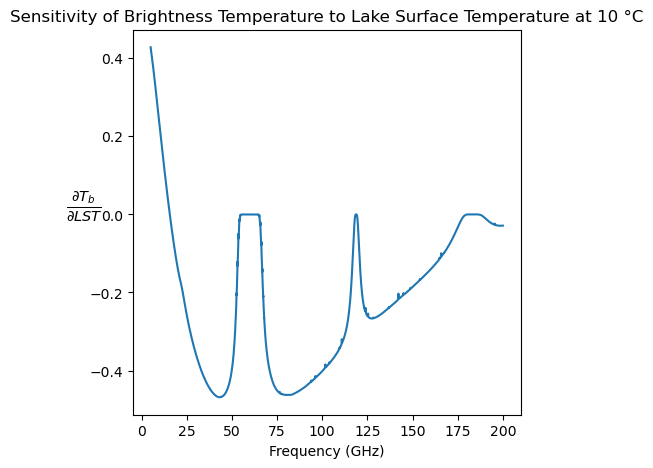

In [234]:
lst = 10
delta_lst = 0.1
dtb_dlst_Rv, dtb_dlst_Rh = tb_sensitivity_lst(lst, delta_lst, freq, t_star_le_cloud)

fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(freq, dtb_dlst_Rv)

ax.set_title("Sensitivity of Brightness Temperature to Lake Surface Temperature at 10 \u00B0C")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$\frac{\partial T_b}{\partial LST}$", rotation = 0, fontsize = 15)

## Sensitivity of Brightness Temperature to LWP

Text(0, 0.5, '$\\frac{\\partial T_b}{\\partial LWP}$')

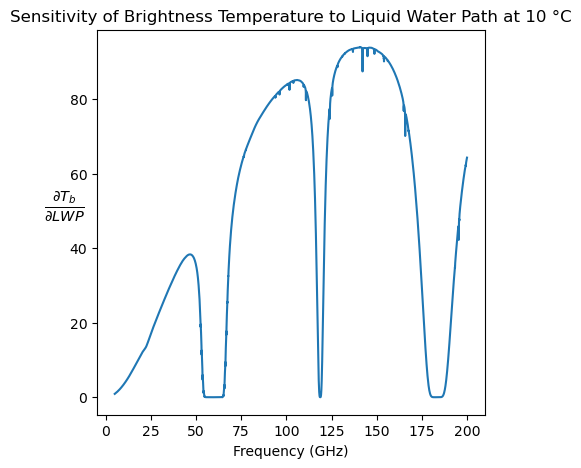

In [237]:
lst = 10
delta_lwp = 0.001
lwp = 0.1 # lake-effect cloud exmaple
dtb_dlwp_Rv, dtb_dlwp_Rh = tb_sensitivity_lwp(lst, lwp, delta_lwp, freq, df_liq_water, df_wv_gases)
                                              
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(freq, dtb_dlwp_Rv)

ax.set_title("Sensitivity of Brightness Temperature to Liquid Water Path at 10 \u00B0C")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$\frac{\partial T_b}{\partial LWP}$", rotation = 0, fontsize = 15)

## Total Uncertainty on LST

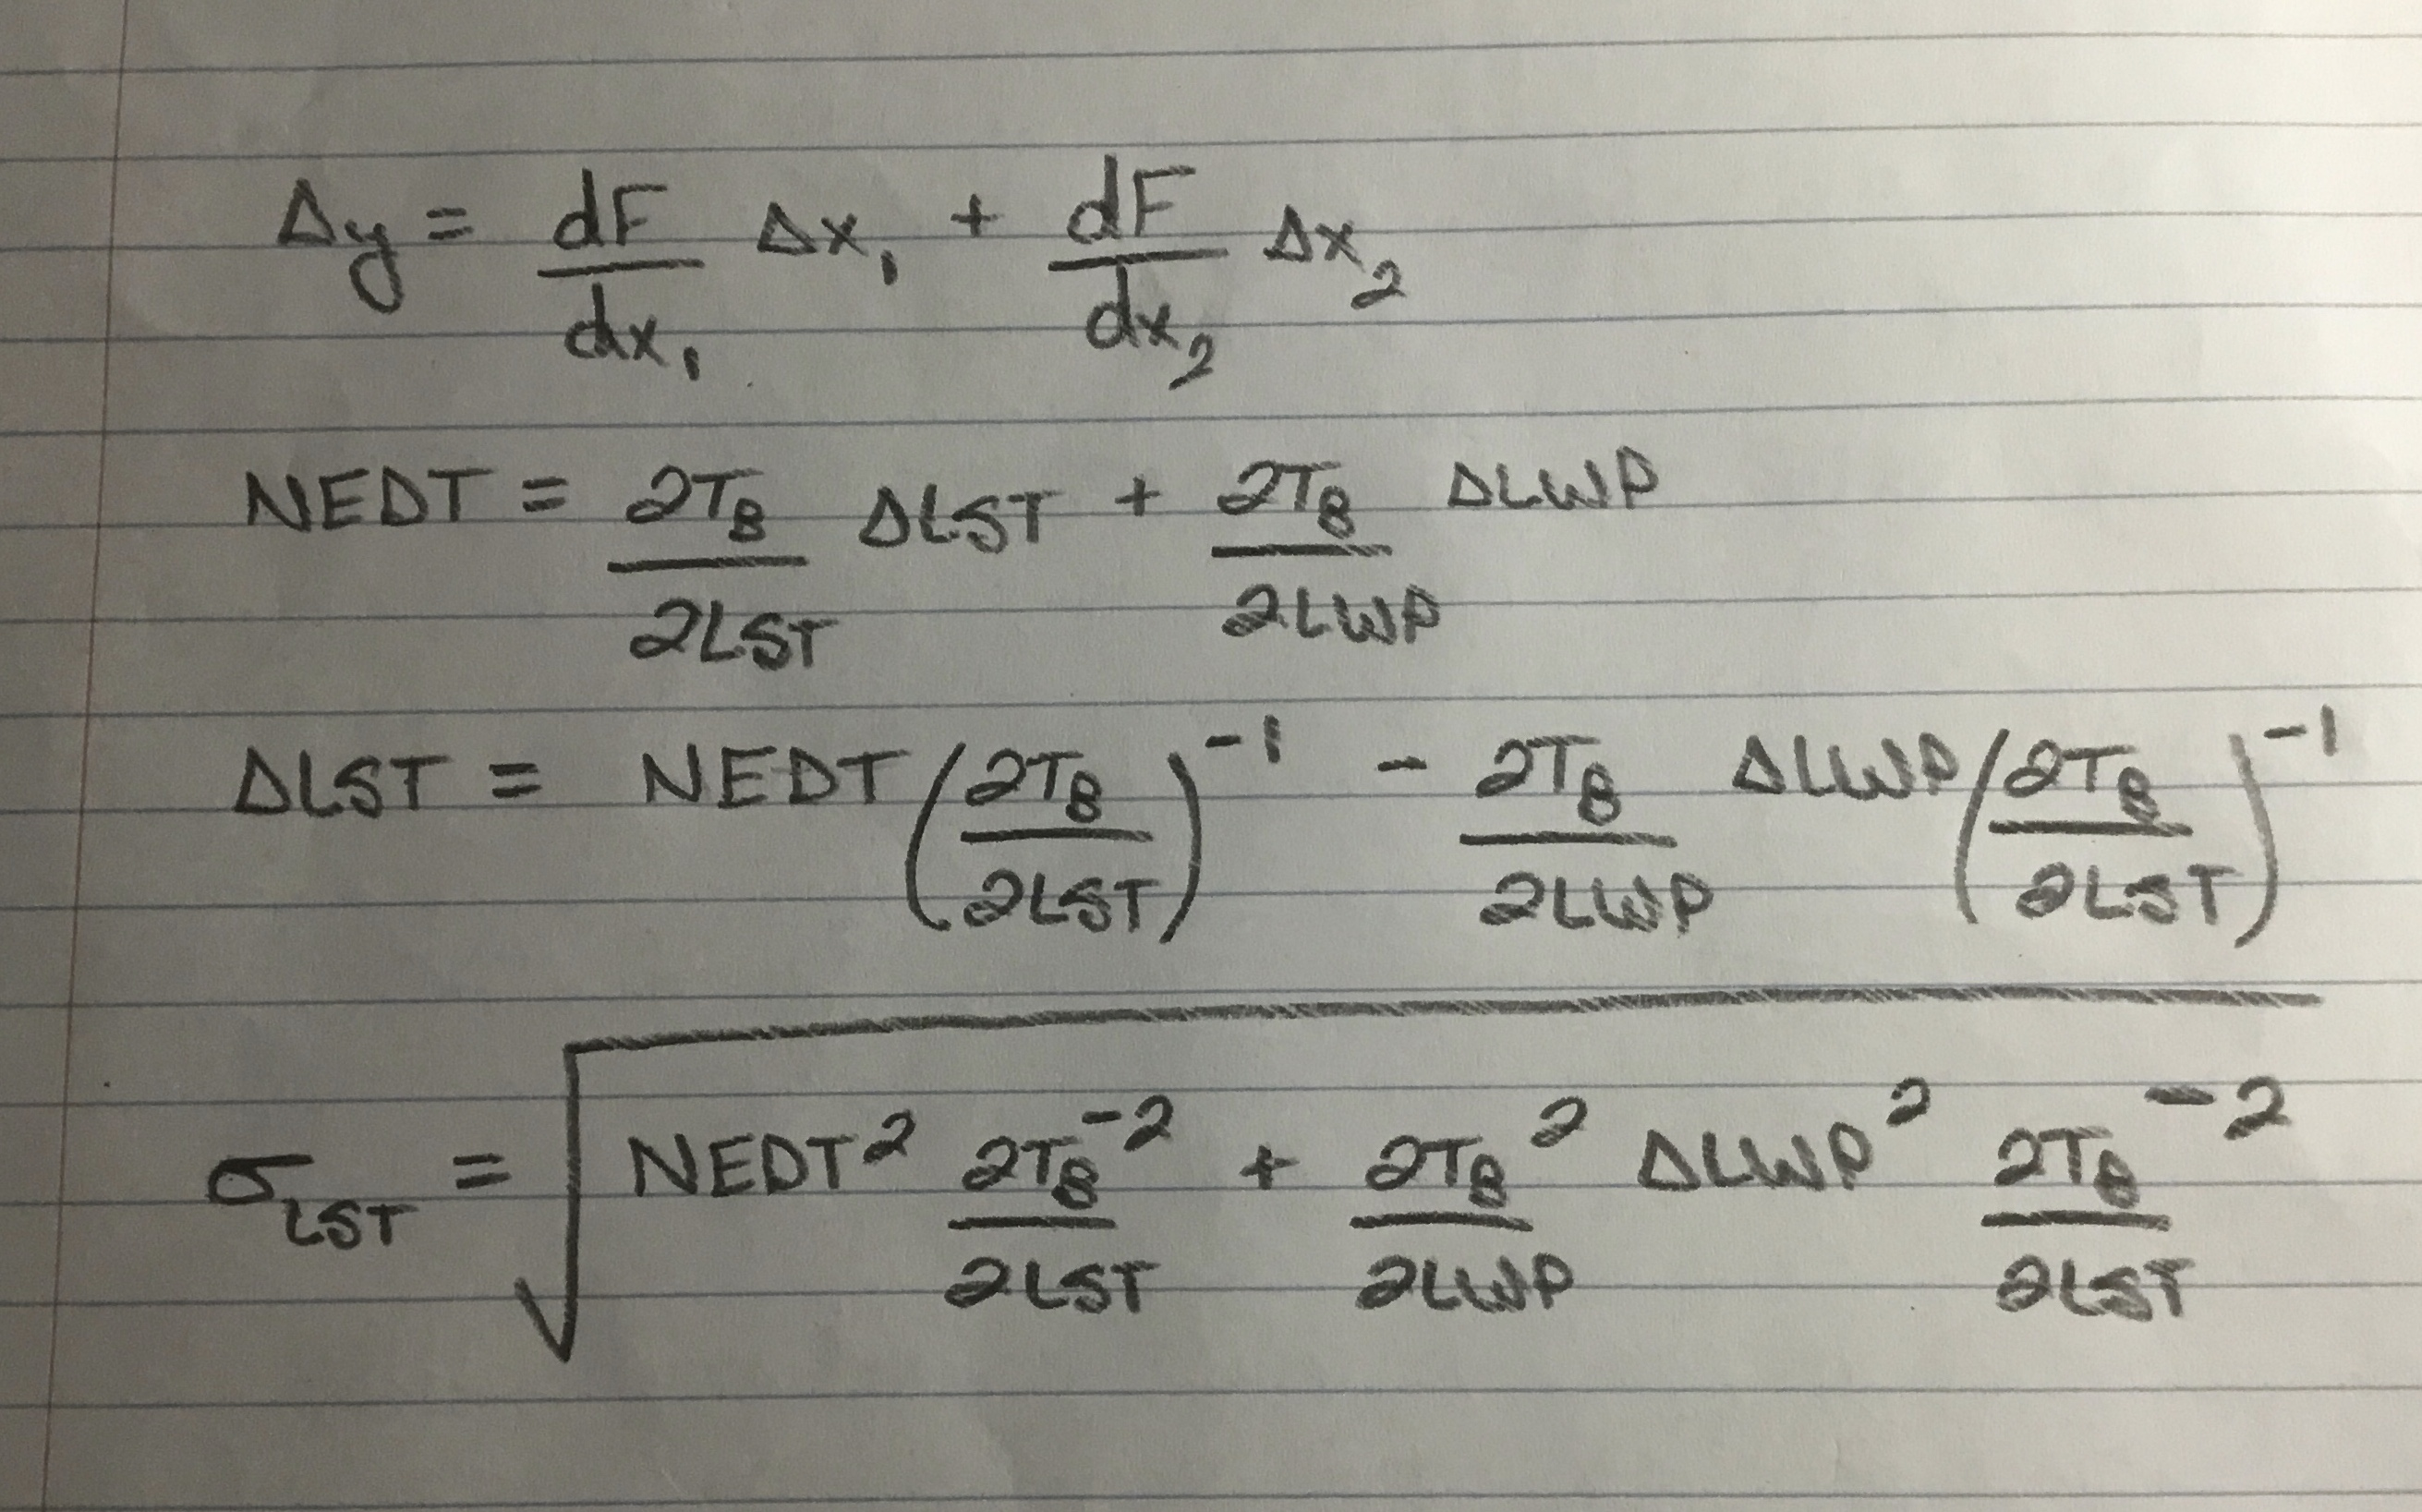

In [265]:
display(Image(filename = 'Uncertainty.jpg', width = 500, height = 500))

C:\Users\nweat\OneDrive\School\Climate 485\Final Project\clim485_project\processing_fns.py:220: RuntimeWarning: divide by zero encountered in power
  term_1 = (NEDT**2) * (dTB_dLST**-2)
C:\Users\nweat\OneDrive\School\Climate 485\Final Project\clim485_project\processing_fns.py:221: RuntimeWarning: divide by zero encountered in power
  term_2 = (delta_LWP**2) * (dTB_dLWP**2) * (dTB_dLST**-2)
C:\Users\nweat\OneDrive\School\Climate 485\Final Project\clim485_project\processing_fns.py:221: RuntimeWarning: invalid value encountered in multiply
  term_2 = (delta_LWP**2) * (dTB_dLWP**2) * (dTB_dLST**-2)


Text(0, 0.5, 'Total Uncertainty (K)')

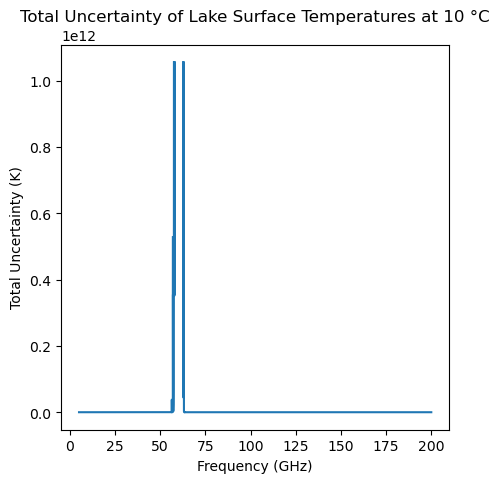

In [249]:
NEDT = 0.3
delta_LWP = 0.1
total_uncert = total_uncertainty(NEDT, dtb_dlst_Rv, dtb_dlwp_Rv, delta_LWP)

fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(freq, total_uncert)


ax.set_title("Total Uncertainty of Lake Surface Temperatures at 10 \u00B0C")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Total Uncertainty (K)")

The crazy values above are due to the thick absorption bands (we obviously don't want to use frequencies there). Below I plotted the total uncertainty in the first several frequencies where the transmission is highest.

Text(0, 0.5, 'Maximum Error (K)')

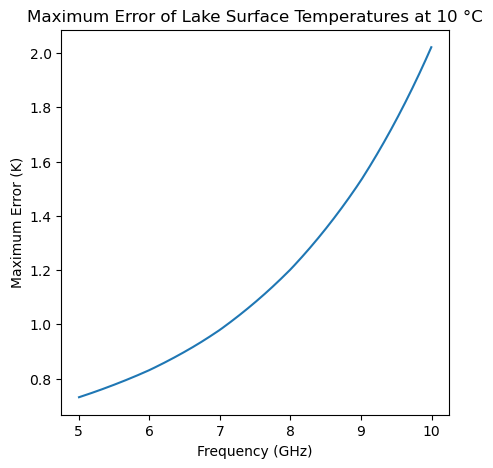

In [260]:
fig, ax = plt.subplots(1, 1, figsize = (5,5))
#ax.plot(freq, total_uncert)
ax.plot(freq[:500], total_uncert[:500])

ax.set_title("Maximum Error of Lake Surface Temperatures at 10 \u00B0C")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Maximum Error (K)")

Text(0, 0.5, 'Maximum Error (K)')

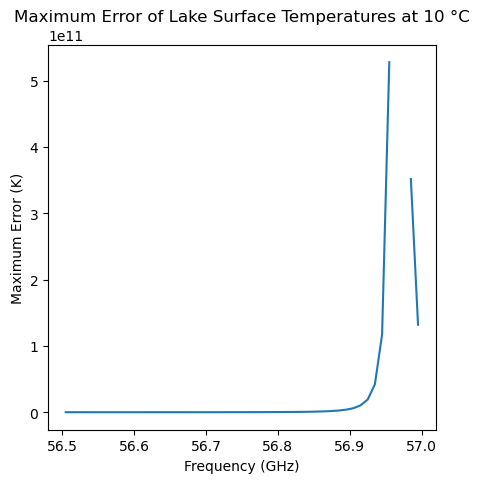

In [276]:
#### IN THE RANGE WHERE I THINK THE CODE IS BUGGING OUT BECAUSE OF ABSORPTION
fig, ax = plt.subplots(1, 1, figsize = (5,5))
#ax.plot(freq, total_uncert)
ax.plot(freq[5150:5200], total_uncert[5150:5200])

ax.set_title("Maximum Error of Lake Surface Temperatures at 10 \u00B0C")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Maximum Error (K)")

In [270]:
# Frequency with the lowest total uncertainty in the range plotted above
freq_lowest_error = freq[np.argmin(total_uncert)]
print(freq_lowest_error)

56.965


In [258]:
# Frequency with the lowest total uncertainty in the range plotted above
freq_lowest_error = freq[np.argmin(total_uncert[:500])]
print(freq_lowest_error)

5.005


The frequency associated with the lowest uncertainty of 5.005 GHz makes sense because, based on the equation we derived for the uncertainty, we would expect the lowest where the sensitivity to the lake surface temperature is maximized and where the sensitivity to liquid water path is minimized. The above sensitivity plots verify that this is true. When I find the frequency associated with the lowest uncertainty over the whole frequency range, it's around 57 GHz. But when I zoomed in the see what it was actually doing, this is on the edge of that major absorption band, and I think the numbers were making it bug out to an unrealistic value. Ask him about this too.